<font size="5"><b>It's no secret that Russia's invasion of Ukraine in 2022 has taken the world by surprise and hardened it. We do not know the exact data on the losses of the Ukrainian army for obvious reasons, but the Kaggle already has good visual presentations of the losses situation on the Russian side. I would like to conduct a cluster analysis of the data and try to identify the stages of the conflict and their differences.</b></font>

<font size="4">Not everyone enjoys reading data science mumbo-jumbo, so we decided to put our key takeaways (updated <b>06/20/2022</b>) here so you can jump right into the main plots - </font>[<font size="4">War Stages plot</font>](#8)<font size="4"> and </font>[<font size="4">FPCA loadings plot</font>](#12).

[<font size="4">War Stages plot</font>](#8)<font size="4">: Based on the analysis of wartime losses, we have identified <b>three</b> stages of the war with turning points on March 16 and May 3. The first stage (February 24 - March 16) is characterized by large daily losses in personnel, which confirms that from the very beginning the invasion was large-scale, but the Russian army was misinformed and not ready for opposition from Ukraine. In the second phase (March 16 - May 3), Ukraine began to report downed aircraft and helicopters more frequently, and personnel losses became less dispersed. The third stage started after May 3 and is different in that Ukraine began to shoot down fewer aircraft and helicopters, but the number of downed drones has seriously increased. This indicates that over time the strategy of the Russians has changed - they have become more cautious and are moving to more defensive maneuvers. We can also see that war stages progressed every <b>three</b> reported high-rank commander eliminations. It might just be a coincidence.</font>
    
[<font size="4">FPCA loadings plot</font>](#12)<font size="4">: <span style="color:#e4002b;">[mumbo-jumbo on]</span> The principal components in the FPCA are the linear combinations of analysed features (losses in our case). These linear combinations are calculated in the way such that they orthogonal to each other and catch for the greatest possible variation in our data. <span style="color:#009f4d;">[mumbo-jumbo off]</span> The loadings plot presents the weights that FPCA assigned to each feature within each principal component. We decided to calculate <b>three</b> main components since the human perception is limited to 3D space. For equipments, the loss of which may be associated with the loss of personnel, we also generated interaction variables. According to 3D plot there are <b>three</b> equipment clusters around personnel. We colored personnel in <span style="color:#0077c8;"><b>blue</b></span>, equipments in <span style="color:#e4002b;"><b>red</b></span> and their interactions in <span style="color:#009f4d;"><b>green</b></span>. The closest cluster contains tanks, APC, aircraft and helicopters, the second cluster contains field artillery, vehicles and fuel tanks, MRL, drones, anti-aircraft warfare and special equipment, while naval ships are in the furthest separate cluster. The interactions of equipment to personnel losses are in the same clusters as their original equipment losses.</font><font size="4"><span style="color:#fe5000;"> Please note that the notebook is scheduled to be updated daily, so results may change as new data becomes available.</span></font>

1. [<font size="4">Installing/importing libraries and loading data</font>](#1)
    1. [<font size="4">Adding information about killed high-rank commanders</font>](#2)
    1. [<font size="4">Killed Russian high-rank commanders</font>](#3)
1. [<font size="4">Data preparation</font>](#4)
1. [<font size="4">Time clustering</font>](#5)
    1. [<font size="4">Dynamic Time Warping</font>](#6)
    1. [<font size="4">Agglomerative Hierarchical Clustering</font>](#7)
    1. [<font size="4">War Stages plot</font>](#8)
1. [<font size="4">Dimensionality reduction with Functional Principal Component Analysis</font>](#9)
    1. [<font size="4">Time Warping</font>](#10)
    1. [<font size="4">PCA functions plot</font>](#11)
    1. [<font size="4">FPCA loadings plot</font>](#12)

<a id="1"></a>
## INSTALLING/IMPORTING LIBRARIES AND LOADING DATA
<font size="4">First, we install needed packages, and load the data. We are dealing with time series, thus we decided to go with Dynamic Time Warping approach to calculate distances between the time points, and then apply hierarchical clustering. Dynamic Time Warping distances we use <b>dtaidistance</b> package.</font>

In [1]:
!pip install fdasrsf
!pip install -v --upgrade --force-reinstall --no-build-isolation --no-binary dtaidistance dtaidistance
import numpy as np 
from numpy import inf
import pandas as pd 

import urllib.request
import requests
import re
from bs4 import BeautifulSoup
import math
from math import floor
from IPython.display import display, Markdown
from PIL import Image, ImageDraw
import requests
import io
from io import BytesIO
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from datetime import datetime
from dtaidistance import dtw

from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import silhouette_visualizer, KElbowVisualizer
import secrets
from fdasrsf import fPCA, time_warping, fdawarp, fdahpca



def replace_last(strr, old, new, place):
    apr = strr.rsplit(old, place)
    return new.join(apr)

# Differenced series
def difference(data, inter=1):
    diff = list()
    for i in range(inter, len(data)):
        value = data[i] - data[i - inter]
        diff.append(value)
    return diff

def printmd(string):
    display(Markdown(string))
#d5th.iloc[:,1:13] = d5th.iloc[:,1:13].apply(difference)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Human losses
ru_losses_pers = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')

# Equipment losses
ru_losses_equip = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')

print(f'This dataset contains information on {ru_losses_pers.shape[0]} day of war.')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 41.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for fdasrsf: filename=fdasrsf-2.3.11-cp37-cp37m-linux_x86_64.whl size=1924573 sha256=19c8dd60ea652bfaf703648e7fc1c44f6b57756017121bd785e9730f46d85e2a
  Stored in directory: /root/.cache/pip/wheels/9e/e0/a4/c6544a50743edc9fdddf4a13a7e773e650633773708d8582ba
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=3119632 sha256=75a3ef89dffc675e64998e5d548f4d46a6aba5294538d250caed0b23052af8a3
  Stored in directory: /root/.cache/pip/w

In [2]:
display(Markdown(f'<font size=4>This dataset contains information on <b>{ru_losses_pers.shape[0]}</b> day of war.</font>'))

<font size=4>This dataset contains information on <b>139</b> day of war.</font>

<a id="2"></a>
### INFORMATION ABOUT KILLED HIGH-RANK COMMANDERS

<font size="4">Let us do one step aside and download additional data about losses in high rank commanders.</font>

In [3]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_Russian_generals_killed_during_the_2022_invasion_of_Ukraine')
soup = BeautifulSoup(page.content, 'html.parser')
generals_soup = soup.find('table',{'class':'wikitable'})
generals = pd.DataFrame(pd.read_html(str(generals_soup))[0])
generals = generals.replace("\[.*?\]", "", regex=True)
generals['Date reported'] = pd.to_datetime(generals['Date reported']).dt.strftime('%Y-%m-%d')
generals2 = generals[['Date reported', 'Status']]
generals.style.set_properties(**{'font-family': 'Segoe UI','font-size': '11pt'}).hide_index()

Name,Rank,Position,Date reported,Status,Notes
Andrey Sukhovetsky,Major General,"Deputy Commander, 41st Combined Arms Army",2022-03-01,Confirmed,"Shot by a sniper at Hostomel on 28 February 2022. Had previously been involved in the Russian military intervention in the Syrian civil war, and 2014 Russian annexation of Crimea. His death was reported by a retired Russian intelligence officer on Twitter on 1 March and by Russian online tabloid Pravda.ru on 3 March 2022."
Andrei Kolesnikov,Major General,"Commander, 29th Combined Arms Army",2022-03-11,Claimed,Killed somewhere near Mariupol.
Oleg Mityaev,Major General,"Commander, 150th Motorized Rifle Division",2022-03-15,Claimed,Killed somewhere near Mariupol.
Yakov Rezantsev,Lieutenant General,"Commander, 49th Combined Arms Army",2022-03-25,Claimed,Ukrainian officials claimed he was killed as a result of a Ukrainian strike on the command post of the 49th Combined Arms Army in the Chornobaivka airfield in the Kherson Raion.
Vladimir Frolov,Major General,"Deputy Commander, 8th Guards Combined Arms Army",2022-04-16,Confirmed,"No information about his death was released prior to the notice of his funeral at Serafimovskoe Cemetery, St. Petersburg."
Andrei Simonov,Major General,"Chief of Electronic Warfare Troops, 2nd Guards Combined Arms Army",2022-04-30,Claimed,"Killed during an artillery strike on a command post of the 2nd Combined Arms Army, in the vicinity of occupied Izium."
Kanamat Botashev,Major General(retired),Unclear,2022-05-22,Confirmed,Killed in the Luhansk region when his Su-25 was shot down by a FIM-92 Stinger missile Botashev had been previously discharged from the Russian Air Force for crashing a Su-27. Ukrainian sources suggested that he might have been deployed as part of the paramilitary organization Wagner Group.
Roman Kutuzov,Lieutenant General,"Commander, 1st Army Corps, Donetsk People's Militia",2022-06-05,Confirmed,"Reported by Russian state television reporter Alexander Sladkov on the Telegram messaging app. Kutuzov was reportedly killed near the village of Mykolaivka, Popasna Raion, Luhansk Oblast. Kutuzov's promotion from major general was announced posthumously."
Artem Nasbulin,Major General,"Chief of Staff, 22nd Army Corps",2022-07-11,Claimed,Ukrainian officials claimed he was killed as a result of a Ukrainian airstrike on the command post of 22nd Army Corps in Kherson city.


<font size="4">Get links to Russian general's wikipedia pages.</font>

In [4]:
display(Markdown(f'<font size=4>! Not every Russian general has a photo on Wikipedia. \
We have added photos of 4 generals to their wiki pages, \
but we still need to define an image to be used if there are new dead generals without a photo.</font>'))
response = requests.get('https://banffventureforum.com/wp-content/uploads/2019/08/No-Image.png')
img = Image.open(BytesIO(response.content)).copy()
no_image = img.resize((220, 272), Image.LANCZOS)

#Get urls
baseURL = 'https://en.wikipedia.org'
URL = 'https://en.wikipedia.org/wiki/List_of_Russian_generals_killed_during_the_2022_invasion_of_Ukraine'

soup = BeautifulSoup(requests.get(URL).content, 'html.parser')
all_links = [] 
# The following will find all `a` tags under the 1st `td` of it's type, which is the first column of the table
for tag in soup.select('td:nth-of-type(1) a'):
    link = (baseURL + str(tag.get('href')))
    link = link.replace(')','%29')
    all_links.append(link)
all_links = all_links[:generals.shape[0]]

<font size=4>! Not every Russian general has a photo on Wikipedia. We have added photos of 4 generals to their wiki pages, but we still need to define an image to be used if there are new dead generals without a photo.</font>

<font size="4">Extracting available images:</font>

In [5]:
gen_img = []
for i, link in enumerate(all_links):
    print(link)
    response = requests.get(link)     
    soup = BeautifulSoup(response.content)    
    covers = soup.select('table.infobox a.image img[src]')
    #print(f'Covers - {len(covers)}')
    if (len(covers) > 0):
        link = 'http:' + covers[0]['src']
        urllib.request.urlretrieve(link,'immmage')
        img = Image.open('immmage').copy()
        img = img.resize((220, 272), Image.LANCZOS)
        if generals['Status'][i] == 'Confirmed':
            draw = ImageDraw.Draw(img) 
            draw.line((0, 0, 220, 272), fill=(0, 87, 183), width=2)
            draw.line((220, 0, 0, 272), fill=(255, 215, 0), width=2)
        gen_img.append(img)
        print(img)
    else:
        if generals['Status'][i] == 'Confirmed':
            img = no_image.copy()
            draw = ImageDraw.Draw(img)
            draw.line((0 ,0, 220, 272), fill=(0, 87, 183), width=2)
            draw.line((220 ,0, 0, 272), fill=(255, 215, 0), width=2)
            gen_img.append(img)
        else:
            gen_img.append(no_image)
        print(no_image)
    print("-" * 50)

https://en.wikipedia.org/wiki/Andrey_Sukhovetsky
<PIL.Image.Image image mode=RGB size=220x272 at 0x7F9E666A0A90>
--------------------------------------------------
https://en.wikipedia.org/wiki/Andrei_Kolesnikov_(general%29
<PIL.Image.Image image mode=RGBA size=220x272 at 0x7F9E92C54110>
--------------------------------------------------
https://en.wikipedia.org/wiki/Oleg_Mityaev_(general%29
<PIL.Image.Image image mode=RGB size=220x272 at 0x7F9E657AF050>
--------------------------------------------------
https://en.wikipedia.org/wiki/Yakov_Rezantsev
<PIL.Image.Image image mode=RGBA size=220x272 at 0x7F9E65797590>
--------------------------------------------------
https://en.wikipedia.org/wiki/Vladimir_Frolov_(general%29
<PIL.Image.Image image mode=RGBA size=220x272 at 0x7F9E65237CD0>
--------------------------------------------------
https://en.wikipedia.org/wiki/Andrei_Simonov
<PIL.Image.Image image mode=RGB size=220x272 at 0x7F9E655E7BD0>
---------------------------------------------

<font size="4">Add the claimed (<b>generals_claimed</b>) and confirmed (<b>generals_confirmed</b>) cases to equipment dataset.</font>

In [6]:
confirmed = []
claimed = []
for i in range(ru_losses_pers.shape[0]):
    if ru_losses_pers['date'][i] in generals2['Date reported'].values:
        claimed.append(1)
        if generals2[generals2['Date reported'] == ru_losses_pers['date'][i]]['Status'].values == 'Confirmed':
            confirmed.append(1)
        else:
            confirmed.append(0)
    else:
        confirmed.append(0)
        claimed.append(0)
        
ru_losses_pers['generals_claimed'] = claimed
ru_losses_pers['generals_confirmed'] = confirmed

<a id="3"></a>
### KILLED RUSSIAN HIGH-RANK COMMANDERS

In [7]:
display(Markdown(f"<font size=4>Claimed number of eliminated generals is {sum(claimed)}, while confirmed by Russian side are only {sum(confirmed)} of them. Let's look at those guys.</font>"))

<font size=4>Claimed number of eliminated generals is 9, while confirmed by Russian side are only 4 of them. Let's look at those guys.</font>

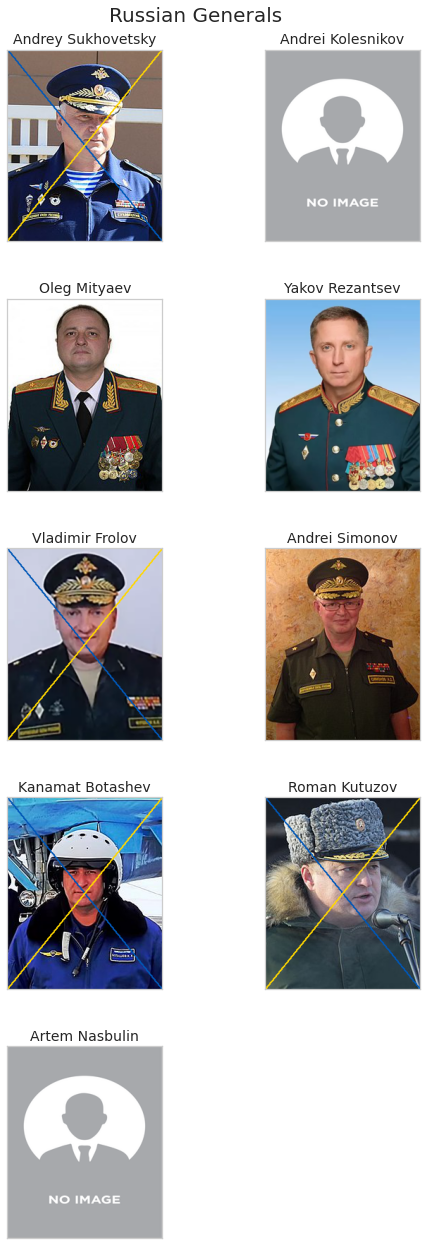

In [8]:
rows = max(math.floor((len(gen_img)+1)/2),1)
cols = math.floor((len(gen_img)+1)/max(math.floor((len(gen_img)+1)/2),1))
f, axs = plt.subplots(nrows = rows,
                      ncols = cols,
                          figsize=(20,20),
                          sharex=True, 
                          sharey=True)
f.suptitle(f'Russian Generals', fontsize=20)
f.subplots_adjust(hspace = 0.3, wspace = -0.7, top = 0.95)
#f.tight_layout()
if len(gen_img)>1:
    axs = axs.ravel()
if len(gen_img)< rows * cols:
    f.delaxes(axs[rows * cols-1])
for i in range(len(gen_img)):
    axs[i].axes.xaxis.set_ticks([])
    axs[i].axes.yaxis.set_ticks([])
    axs[i].set_aspect('equal')
    axs[i].set_title(f"{generals['Name'][i]}", fontsize=14)
    axs[i].imshow(gen_img[i])

<a id="4"></a>
## DATA PREPARATION

In [9]:
ru_losses_pers.head().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'}).hide_index()

date,day,personnel,personnel*,POW,generals_claimed,generals_confirmed
2022-02-25,2,2800,about,0,0,0
2022-02-26,3,4300,about,0,0,0
2022-02-27,4,4500,about,0,0,0
2022-02-28,5,5300,about,0,0,0
2022-03-01,6,5710,about,200,1,1


<font size="4">Looks like <b>POW</b> is outdated. Will deal with it later. If we add it now the clustering algorithm will obviously identify additional period when data on POW stopped to be reported.</font>

In [10]:
fig = px.line(ru_losses_pers, x='date', y='POW')
fig.show()

In [11]:
ru_losses_pers.describe().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'})

,day,personnel,POW,generals_claimed,generals_confirmed
count,139.000000,139.000000,139.000000,139.000000,139.000000
mean,71.000000,24105.007194,448.043165,0.064748,0.028777
std,40.269923,8945.087702,103.538124,0.246971,0.167784
min,2.000000,2800.000000,0.000000,0.000000,0.000000
25%,36.500000,17600.000000,459.000000,0.000000,0.000000
50%,71.000000,24700.000000,496.000000,0.000000,0.000000
75%,105.500000,31600.000000,498.000000,0.000000,0.000000
max,140.000000,37570.000000,498.000000,1.000000,1.000000


In [12]:
printmd(f"<font size=4>Personnel losses data \
        \n\nFirst day: {ru_losses_pers['date'][0]} \
        \nLast day: {ru_losses_pers['date'].values[-1]} \
        \nTotal days: {ru_losses_pers.shape[0]}")

<font size=4>Personnel losses data         

First day: 2022-02-25         
Last day: 2022-07-13         
Total days: 139

In [13]:
printmd(f"<font size=4>Equipment losses data \
        \n\nFirst day: {ru_losses_equip['date'][0]} \
        \nLast day: {ru_losses_equip['date'].values[-1]} \
        \nTotal days: {ru_losses_equip.shape[0]}")

<font size=4>Equipment losses data         

First day: 2022-02-25         
Last day: 2022-07-13         
Total days: 139

<font size="4">Selecting relevant data from personnel and equipment datasets.</font>

In [14]:
d1st = ru_losses_pers[['day', 'personnel']] #add POW later (generals?)
d2nd = ru_losses_equip.iloc[:,1:]

<font size="4">Checking missing values for both datasets.</font>

In [15]:
d1st.isnull().sum()

day          0
personnel    0
dtype: int64

In [16]:
d2nd.isnull().sum()

day                            0
aircraft                       0
helicopter                     0
tank                           0
APC                            0
field artillery                0
MRL                            0
military auto                 74
fuel tank                     74
drone                          0
naval ship                     0
anti-aircraft warfare          0
special equipment             19
mobile SRBM system           103
vehicles and fuel tanks       65
cruise missiles               65
greatest losses direction     89
dtype: int64

<font size="4">To deal with the missing values for <b>military vehicles</b> and <b>fuel tanks</b>, we will sum the existing values and concatenate them with the variable <b>vehicles and fuel tanks</b>.</font>

In [17]:
d2nd['vehicles and fuel tanks'].fillna(d2nd['military auto'] + d2nd['fuel tank'], inplace = True)

In [18]:
d3rd = pd.merge(d1st, d2nd, how='outer', on=['day'])

<font size="4">The variables <b>mobile SRBM system</b> and <b>cruise missiles</b> have too many missing values, so we decided to omit them as well.</font>

In [19]:
d3rd = d3rd.drop(columns  = ['military auto','fuel tank','mobile SRBM system','cruise missiles'])

In [20]:
d3rd.head().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'}).hide_index()

day,personnel,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,greatest losses direction
2,2800,10,7,80,516,49,4,0,2,0,nan,160.000000,nan
3,4300,27,26,146,706,49,4,2,2,0,nan,190.000000,nan
4,4500,27,26,150,706,50,4,2,2,0,nan,190.000000,nan
5,5300,29,29,150,816,74,21,3,2,5,nan,351.000000,nan
6,5710,29,29,198,846,77,24,3,2,7,nan,365.000000,nan


<font size="4"> <b>Special equipment</b> has some missing values which will be replaced with interpolated estimates.</font>

In [21]:
d3rd.loc[0, 'special equipment'] = 0
d3rd['special equipment'] = pd.Series(d3rd['special equipment']).interpolate().round()

In [22]:
d3rd.isnull().sum()

day                           0
personnel                     0
aircraft                      0
helicopter                    0
tank                          0
APC                           0
field artillery               0
MRL                           0
drone                         0
naval ship                    0
anti-aircraft warfare         0
special equipment             0
vehicles and fuel tanks       0
greatest losses direction    89
dtype: int64

<font size="4">You can't use the <b>direction of greatest loss</b> yet.</font>

In [23]:
pd.crosstab(index=d3rd['greatest losses direction'], columns='count').style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'})

col_0,count
greatest losses direction,
Avdiivka,3
Avdiivka and Bakhmut,1
Avdiivka and Kryvyi Rih,1
Bahmut,12
Bahmut and Avdiivka,1
Bahmut and Kurakhove,3
Bahmut and Sievierodonetsk,1
Bahmut and Zaporizhzhia,2
Bakhmut,3


In [24]:
d4th = d3rd.drop(columns = ['greatest losses direction', 'day'])

In [25]:
d4th.head().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'}).hide_index()

personnel,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks
2800,10,7,80,516,49,4,0,2,0,0.000000,160.000000
4300,27,26,146,706,49,4,2,2,0,1.000000,190.000000
4500,27,26,150,706,50,4,2,2,0,1.000000,190.000000
5300,29,29,150,816,74,21,3,2,5,2.000000,351.000000
5710,29,29,198,846,77,24,3,2,7,2.000000,365.000000


In [26]:
d4th.describe().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'})

,personnel,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,24105.007194,165.187050,145.625899,1002.201439,2532.345324,482.848921,156.827338,318.863309,9.517986,72.654676,35.712230,1768.071942
std,8945.087702,59.879053,42.656918,455.920508,963.344677,234.034121,70.296982,245.077633,4.361147,28.761063,19.534156,717.388840
min,2800.000000,10.000000,7.000000,80.000000,516.000000,49.000000,4.000000,0.000000,2.000000,0.000000,0.000000,160.000000
25%,17600.000000,139.000000,131.000000,619.500000,1743.000000,313.500000,96.000000,84.000000,7.000000,54.000000,23.000000,1286.000000
50%,24700.000000,196.000000,155.000000,1092.000000,2651.000000,499.000000,169.000000,312.000000,10.000000,83.000000,38.000000,1907.000000
75%,31600.000000,212.000000,178.000000,1395.500000,3433.500000,707.000000,213.000000,560.500000,13.000000,96.000000,53.000000,2413.500000
max,37570.000000,217.000000,188.000000,1649.000000,3832.000000,839.000000,247.000000,678.000000,15.000000,109.000000,67.000000,2704.000000


<font size="4">Let's normalize our data. The normalization is nessessary for this kind of data, but simple transformations to standard Gauss may not be the optimal strategy in time series. In some time series you may want to account for changes in summary statistics over time, thus, some sort of moving normalization: normalized_df[t] = (df[t] - mean(df[t-14:t])) / std(df[t-14:t]) might be better solution.</font>

In [27]:
#normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df=(d4th-d4th.mean())/d4th.std()
d4th = normalized_df

In [28]:
d4th.head().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'}).hide_index()

personnel,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks
-2.381755,-2.591675,-3.249787,-2.022724,-2.093067,-1.853785,-2.174024,-1.301071,-1.723855,-2.526147,-1.828194,-2.241563
-2.214065,-2.307769,-2.804373,-1.877962,-1.895838,-1.853785,-2.174024,-1.292910,-1.723855,-2.526147,-1.777002,-2.199744
-2.191707,-2.307769,-2.804373,-1.869189,-1.895838,-1.849512,-2.174024,-1.292910,-1.723855,-2.526147,-1.777002,-2.199744
-2.102272,-2.274369,-2.734044,-1.869189,-1.781652,-1.746963,-1.932193,-1.288830,-1.723855,-2.352301,-1.725809,-1.975319
-2.056437,-2.274369,-2.734044,-1.763907,-1.750511,-1.734144,-1.889517,-1.288830,-1.723855,-2.282763,-1.725809,-1.955804


In [29]:
series = np.array(d4th)
#series2 = [srs[~np.isnan(srs)] for srs in series]

<a id="5"></a>
## TIME CLUSTERING

<a id="6"></a>
### DYNAMIC TIME WARPING

<font size="4">Dynamic Time Warping distance matrix</font>

In [30]:
#from dtaidistance import dtw
ds = dtw.distance_matrix_fast(series)
ds[ds == inf] = 0

<a id="7"></a>
### AGGLOMERATIVE HIERARCHICAL CLUSTERING

<font size="4">Clustering is done using Agglomerative Hierarchical Clustering. To select optimal number of clusters we will use Calinski-Harabasz, Distortion and Silhouette scores. We won't show all tests and comparisons, but with ‘average’ linkage, the optimal number of clusters is three (*20//06/2022*).</font>

In [31]:
#linkage{‘ward’, ‘complete’, ‘average’, ‘single’}
cluster = AgglomerativeClustering(affinity='precomputed', linkage='average', compute_distances = True)

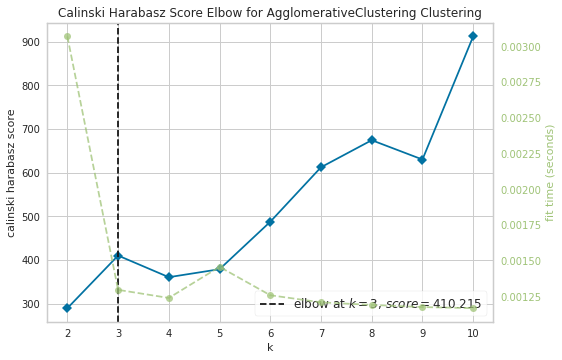

In [32]:
nclust_opt = []
visualizer = KElbowVisualizer(cluster, k = 10, n_clusters=(2,10), metric='calinski_harabasz',
                              timings=True,locate_elbow=True)
visualizer.fit(ds)        
visualizer.show()
nclust_opt.append(visualizer.elbow_value_)

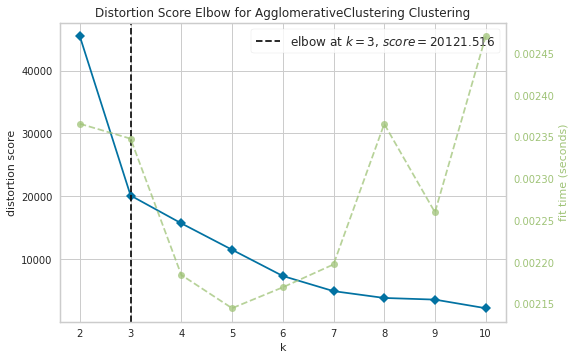

In [33]:
visualizer = KElbowVisualizer(cluster, k = 10, n_clusters=(2,10),
                              metric='distortion', timings=True)
visualizer.fit(ds)       
visualizer.show()
nclust_opt.append(visualizer.elbow_value_)

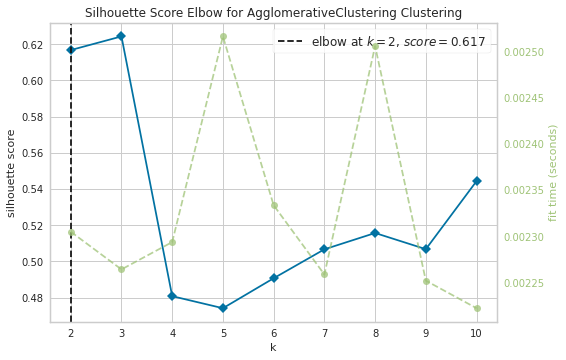

In [34]:
visualizer = KElbowVisualizer(cluster, k = 10, n_clusters=(2,10),
                              metric='silhouette', timings=True)
visualizer.fit(ds)
visualizer.show()
nclust_opt.append(visualizer.k_scores_.index(max(visualizer.k_scores_))+2)

In [35]:
if len(nclust_opt) == len(set(nclust_opt)):
    nclust = nclust_opt[-1]
else:    
    nclust = max(set(nclust_opt), key = nclust_opt.count)
#nclust = 4
cluster = AgglomerativeClustering(n_clusters = nclust, affinity='precomputed',
                                  linkage='average', compute_distances = True)
cls_fitted = cluster.fit(ds)
pd.crosstab(index=cls_fitted.labels_, columns='count').style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'})

col_0,count
row_0,
0,72
1,28
2,39


In [36]:
display(Markdown(f"<font size=4>We got {nclust} clusters. Let's add the estimated clusters to our data.</font>"))

<font size=4>We got 3 clusters. Let's add the estimated clusters to our data.</font>

In [37]:
d5th = d4th.copy()
d5th['date'] = ru_losses_pers['date']
d5th['clusters'] = cls_fitted.labels_

<font size="4">The following code snippet will order the clusters and assign colors in a certain way.</font>

In [38]:
color_date = []

for clust in d5th['clusters'].unique():
    ch = secrets.choice(d5th[d5th['clusters'] == clust]['date'].values) 
    color_date.append([clust, ch])
    
color_date = pd.DataFrame(color_date).sort_values(by = [1])
color_palette = ['#e4002b', '#fe5000', '#efdf00', '#84bd00', '#009f4d', '#008eaa', '#0077c8', '#8e43e7', '#a51890', '#da1884']

color_palette = color_palette[:nclust]

color_dict = dict(zip(color_date.iloc[:,0], color_palette))
d5th['colors'] = d5th['clusters'].replace(color_dict)

cplt = []
for i, clr in enumerate(color_palette):
    cplt.append(f'<code style="color:white; background-color: {clr}"><b>{i+1}</b></code>')
cplt2 = '-'.join(cplt)
cplt = cplt2

In [39]:
pd.crosstab(index=d5th['colors'], columns='count').style.set_properties(**{'font-family': 'Segoe UI','font-size': '11pt'})

col_0,count
colors,
#e4002b,28
#efdf00,72
#fe5000,39


<font size="4">Define plot borders.</font>

In [40]:
data_max = d5th.iloc[:,:12].max().max() + 0.1
data_min = d5th.iloc[:,:12].min().min() - 0.1

<font size="4">This code defines a table containing the data needed to create colored areas on the future plot.</font>

In [41]:
start_date = []
end_date = []
clust_color = []
for clust in d5th['clusters'].unique():
    *head, last =  d5th['date'][d5th['clusters'] == clust]
    start_date.append(d5th['date'][d5th['clusters'] == clust].values[0])
    end_date.append(last)
    clust_color.append(d5th[d5th['date'] == last]['colors'].values[0])
df_dates = pd.DataFrame({'start_date' : start_date, 
                         'end_date' : end_date, 
                         'cluster' : d5th['clusters'].unique(), 
                         'clust_color' : clust_color})
df_dates.head().style.set_properties(**{'font-family': 'Segoe UI','font-size': '14pt'})

,start_date,end_date,cluster,clust_color
0,2022-02-25,2022-03-24,1,#e4002b
1,2022-03-25,2022-05-02,2,#fe5000
2,2022-05-03,2022-07-13,0,#efdf00


<font size="4">This part defines the set of parameters for regions coloring.</font>

In [42]:
shapes = []
for clust in df_dates['cluster']:
    strt_date = datetime.date(pd.to_datetime(df_dates[df_dates['cluster'] == clust]['start_date'].values[0]) 
                              - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    end_date = datetime.date(pd.to_datetime(df_dates[df_dates['cluster'] == clust]['end_date'].values[0]) 
                              + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    dic_clust = dict(type = 'rect',
                     xref = 'x',
                     yref = 'y',
                     x0 = df_dates[df_dates['cluster'] == clust]['start_date'].values[0],
                     y0 = data_min,
                     x1 = end_date,
                     y1 = data_max,
                     fillcolor = df_dates[df_dates['cluster'] == clust]['clust_color'].values[0],
                     opacity = 0.35,
                     line_width = 0,
                     layer = 'below')
    shapes.append(dic_clust)

In [43]:
d5th.head().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'}).hide_index()

personnel,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,date,clusters,colors
-2.381755,-2.591675,-3.249787,-2.022724,-2.093067,-1.853785,-2.174024,-1.301071,-1.723855,-2.526147,-1.828194,-2.241563,2022-02-25,1,#e4002b
-2.214065,-2.307769,-2.804373,-1.877962,-1.895838,-1.853785,-2.174024,-1.292910,-1.723855,-2.526147,-1.777002,-2.199744,2022-02-26,1,#e4002b
-2.191707,-2.307769,-2.804373,-1.869189,-1.895838,-1.849512,-2.174024,-1.292910,-1.723855,-2.526147,-1.777002,-2.199744,2022-02-27,1,#e4002b
-2.102272,-2.274369,-2.734044,-1.869189,-1.781652,-1.746963,-1.932193,-1.288830,-1.723855,-2.352301,-1.725809,-1.975319,2022-02-28,1,#e4002b
-2.056437,-2.274369,-2.734044,-1.763907,-1.750511,-1.734144,-1.889517,-1.288830,-1.723855,-2.282763,-1.725809,-1.955804,2022-03-01,1,#e4002b


In [44]:
text_date = []
for i in start_date[1:]:
    text_date.append(datetime.strptime(i, '%Y-%m-%d').strftime('%b-%d-%Y').title()[:-5].replace('-',' '))
text_date = ', '.join(text_date)
text_date = replace_last(text_date,', ', ' and ',1)

<a id="8"></a>
### WAR STAGES PLOT

In [45]:
display(Markdown(f"<font size=4><b>The plot!</b> Agglomerative Clustering over Dynamic Time Warping for Russia's losses during the invasion of Ukraine in 2022 shows {visualizer.elbow_value_} ({cplt}) stages of the conflict.\
The turning points are on <b>{text_date}</b>. The data has been normalized so we can observe changes on a similar scale. \
What is interesting is that drones are becoming more frequent, as opposed to airplanes and helicopters.\
If at first it was difficult for Ukraine to fight the Russian Air Force, then in the middle stage something happened, \
and Ukraine began to report victories in air battles more often, which led to the third stage, \
in which the Russians began to fly less and use more drones. \
We also added the reported and confirmed high rank commander losses - reported ones are marked with simple <font color='#418A23'><b>green star</b></font>, \
while confirmed ones are also framed in <font color='#F50707'><b>red</b></font>."))

<font size=4><b>The plot!</b> Agglomerative Clustering over Dynamic Time Warping for Russia's losses during the invasion of Ukraine in 2022 shows 2 (<code style="color:white; background-color: #e4002b"><b>1</b></code>-<code style="color:white; background-color: #fe5000"><b>2</b></code>-<code style="color:white; background-color: #efdf00"><b>3</b></code>) stages of the conflict.The turning points are on <b>Mar 25 and May 03</b>. The data has been normalized so we can observe changes on a similar scale. What is interesting is that drones are becoming more frequent, as opposed to airplanes and helicopters.If at first it was difficult for Ukraine to fight the Russian Air Force, then in the middle stage something happened, and Ukraine began to report victories in air battles more often, which led to the third stage, in which the Russians began to fly less and use more drones. We also added the reported and confirmed high rank commander losses - reported ones are marked with simple <font color='#418A23'><b>green star</b></font>, while confirmed ones are also framed in <font color='#F50707'><b>red</b></font>.

In [46]:
general_y = d5th[d5th.date.isin(ru_losses_pers[ru_losses_pers['generals_claimed']==1]['date'].values)]['personnel']
init_notebook_mode(connected=True)
fig = go.Figure()
fig.update_layout(autosize=False, width=1500, height=1000)
for i,feature in enumerate(d5th.iloc[0:,0:12]):
    if feature == 'personnel':
        fig.add_trace(go.Scatter(x=d5th['date'], y=d5th[feature],
                                 mode='lines+markers',
                                 name=feature,
                                 line_color = '#466542',
                                 line_width = 1.75,
                                 marker_size = 9
                                ))
    else: 
        fig.add_trace(go.Scatter(x=d5th['date'], y=d5th[feature],
                                 mode='lines+markers',
                                 name=feature,
                                 line_color = px.colors.qualitative.Dark24[i+2],
                                 line_width = 1,
                                 marker_size = 4
                                ))
fig.add_trace(go.Scatter(x=ru_losses_pers[ru_losses_pers['generals_claimed']==1]['date'].values, 
                         y=general_y,
                         mode='markers',
                         name='Generals confirmed',
                         marker_size = 15,
                         marker_color = '#418A23',
                         marker_line_color='#F50707',
                         marker_line_width=ru_losses_pers[ru_losses_pers['generals_claimed']==1]['generals_confirmed'].values*2,
                         marker_symbol='star',
                         text = generals['Name']
                         
                        ))
fig.update_xaxes(range=[d5th['date'][0], d5th['date'][len(d5th['date']) - 1]], tickangle = 45, nticks = 25, tickmode = 'auto',showgrid=True)
fig.update_yaxes(range=[data_min, data_max],showgrid=False)
fig.update_layout(shapes=shapes)
fig.show()

<a id="9"></a>
## DIMENSIONALITY REDUCTION WITH FUNCTIONAL PRINCIPAL COMPONENT ANALYSIS

<font size="4"><b>LET'S THINK ABOUT POSSIBLE DIMENSIONALITY REDUCTION METHOD FOR TIME SERIES.</b>
The first that comes to my mind is Functional Principal Components Analysis (FPCA) and its offsprings. One problem with FPCA is that it tends to ignore local features. The Wavelet transform methodology (WT) can be possible solution. Singular Value Decomposition (SVD) and Uniform Manifold Approximation and Projection (UMAP) are another methods that can be adapted for time series featurewise dimensionality reduction. For timewise dimensionality reduction the Piecewise Aggregate Approximation based methods can be used. For example, the multivariate version of Symbolic Aggregate approXimation (MSAX). </font>


<font size="4">We will use FPCA, but first we should think about interaction between personnel and equipment losses.</font>

In [47]:
d4th = d3rd.drop(columns = ['greatest losses direction', 'day'])
d4th = d4th.apply(difference)
d4th.iloc[:,1:].tail().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'}).hide_index()

aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks
0,0,1,4,4,0,5,0,1,0.000000,2.000000
0,1,3,8,2,0,2,0,0,0.000000,7.000000
0,0,4,5,4,0,0,0,1,0.000000,2.000000
0,0,4,1,0,0,0,0,0,0.000000,3.000000
0,0,0,3,1,0,2,0,0,1.000000,5.000000


In [48]:
for feature in d4th.iloc[:,1:]:
    if feature not in ['drone']:
        d4th[f"persX{feature}"] =  d4th[feature] * d4th['personnel'] 
d4th.head().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'}).hide_index()

personnel,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,persXaircraft,persXhelicopter,persXtank,persXAPC,persXfield artillery,persXMRL,persXnaval ship,persXanti-aircraft warfare,persXspecial equipment,persXvehicles and fuel tanks
1500,17,19,66,190,0,0,2,0,0,1.000000,30.000000,25500,28500,99000,285000,0,0,0,0,1500.000000,45000.000000
200,0,0,4,0,1,0,0,0,0,0.000000,0.000000,0,0,800,0,200,0,0,0,0.000000,0.000000
800,2,3,0,110,24,17,1,0,5,1.000000,161.000000,1600,2400,0,88000,19200,13600,0,4000,800.000000,128800.000000
410,0,0,48,30,3,3,0,0,2,0.000000,14.000000,0,0,19680,12300,1230,1230,0,820,0.000000,5740.000000
130,1,2,13,16,8,16,0,0,2,1.000000,50.000000,130,260,1690,2080,1040,2080,0,260,130.000000,6500.000000


In [49]:
#normalized_df=(d4th-d4th.min())/(d4th.max()-d4th.min())
normalized_df=(d4th-d4th.mean())/d4th.std()
d4th = normalized_df
print(d4th.shape)
d4th.head().style.set_properties(**{'font-family': 'Segoe UI','font-size': '12pt'}).hide_index()

(138, 22)


personnel,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,persXaircraft,persXhelicopter,persXtank,persXAPC,persXfield artillery,persXMRL,persXnaval ship,persXanti-aircraft warfare,persXspecial equipment,persXvehicles and fuel tanks
3.773287,6.127961,6.038359,5.864591,7.597960,-1.058977,-0.619990,-0.608576,-0.277610,-0.581337,0.583612,0.515881,10.842171,10.014761,10.523401,10.048005,-0.594072,-0.365232,-0.235058,-0.350773,4.923166,2.825341
-0.157083,-0.593029,-0.447744,-0.791125,-1.100019,-0.873991,-0.619990,-1.026404,-0.277610,-0.581337,-0.550732,-0.822307,-0.235344,-0.214463,-0.306811,-0.324414,-0.515007,-0.365232,-0.235058,-0.350773,-0.446315,-0.423687
1.656934,0.197676,0.576378,-1.220526,3.935653,3.380683,5.365596,-0.817490,-0.277610,3.098689,0.583612,6.359303,0.459715,0.646946,-0.395041,2.878298,6.996114,8.954764,-0.235058,4.636262,2.417408,8.875753
0.477823,-0.593029,-0.447744,3.932287,0.273346,-0.504019,0.436290,-1.026404,-0.277610,0.890673,-0.550732,-0.197819,-0.235344,-0.214463,1.775413,0.123238,-0.107826,0.477680,-0.235058,0.671569,-0.446315,-0.009255
-0.368719,-0.197676,0.235004,0.175028,-0.367558,0.420910,5.013503,-1.026404,-0.277610,0.890673,0.583612,1.408007,-0.178871,-0.121143,-0.208656,-0.248713,-0.182937,1.060179,-0.235058,-0.026616,0.019040,0.045617


In [50]:
fig = go.Figure()
fig.update_layout(autosize=True, 
                  width=1500, 
                  height=700,
                  #xaxis = dict(),
                  title_text='<b>Normalized losses over time (with interactions)</b>', 
                  title_x=0.5,
                  font_size = 15,
                  xaxis = dict(range=[-0.5,d4th.shape[0]-0.5],
                               ticktext = d5th['date'][::3],
                               tickvals = list(range(0,len(d5th['date'])))[::3],
                               tickangle = 45,
                               tickmode = 'array',
                               tickfont=dict(size=10)
                               )
                 )
for i,feature in enumerate(d4th):
        fig.add_trace(go.Scatter(x=d4th.index, y=d4th[feature],
                                 mode='lines+markers',
                                 name=feature,
                                 line_color = px.colors.qualitative.Dark24[i],
                                 line_width = 1,
                                 marker_size = 4,
                                 text = d5th['date'][i]
                                ))
fig.show()


In [51]:
funky = d4th.to_numpy().astype(float)
time = np.linspace(0,1,len(funky))

<a id="10"></a>
### TIME WARPING

<font size="4">Warping functions below and above diagonal push original functions later or sooner in time line, respectively.</font>

In [52]:
warp_funky = time_warping.fdawarp(funky, time)
warp_funky.srsf_align(MaxItr = 100)

Initializing...
Compute Karcher Mean of 22 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
updating step: r=21
updating step: r=22
updating step: r=23
updating step: r=24
updating step: r=25
updating step: r=26
updating step: r=27
updating step: r=28
updating step: r=29
updating step: r=30
updating step: r=31
updating step: r=32
updating step: r=33
updating step: r=34
updating step: r=35
updating step: r=36
updating step: r=37
updating step: r=38
updating step: r=39
updating step: r=40
updating step: r=41
updating step: r=42
updating step: r=43
updating step: r=44
updating step: r=45
updating step: r=46
updating step: r=47


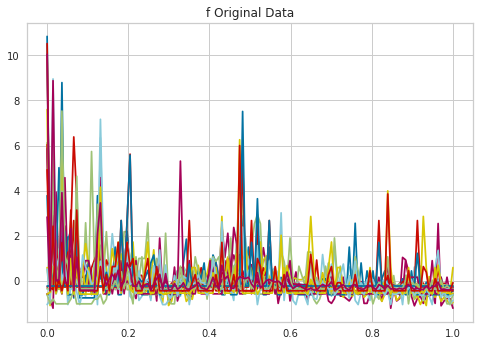

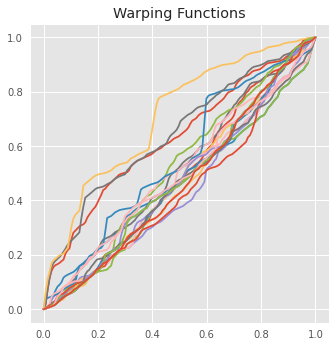

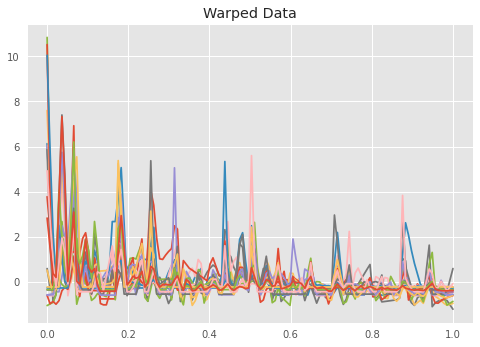

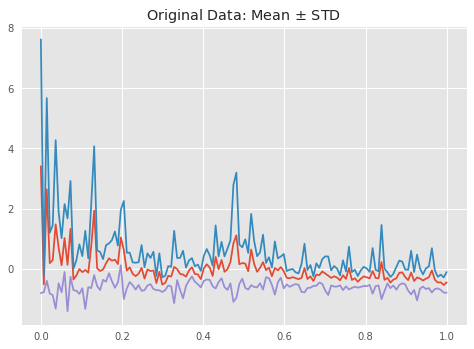

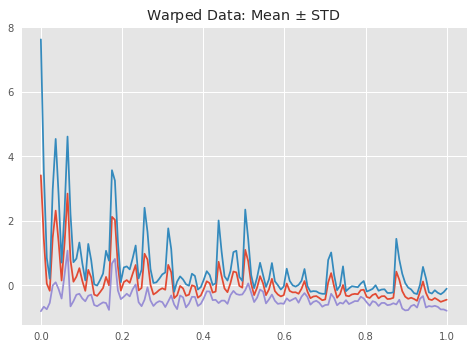

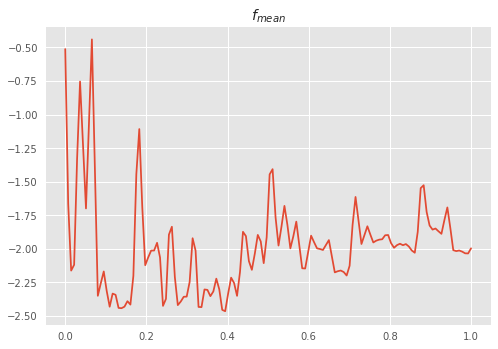

In [53]:
warp_funky.plot()

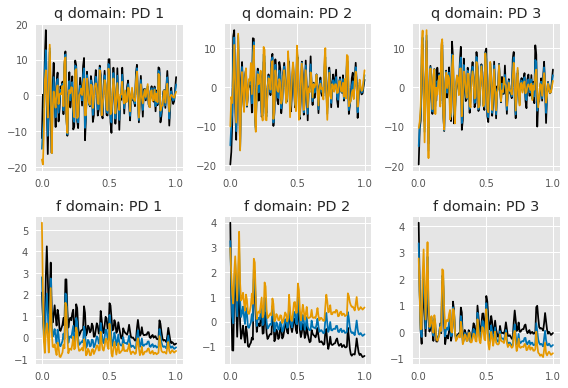

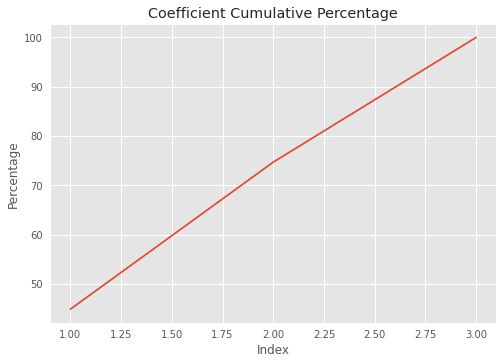

In [54]:
fPCA_analysis = fPCA.fdavpca(warp_funky)
n_pca = 3
fPCA_analysis.calc_fpca(no=n_pca)
fPCA_analysis.plot()

<a id="11"></a>
### PCA FUNCTIONS

In [55]:
clr = ['#e4002b', '#009f4d',  '#0077c8']
fig = go.Figure()
for i in range(0, n_pca):   
    fig.add_trace(go.Scatter(y=fPCA_analysis.f_pca[:,0,i], 
                             mode='lines', 
                             name=f'PC{i+1}',
                             line=dict(color=clr[i]),
                             text = d5th['date']
                            )
                 )
fig.update_layout(autosize=True, 
                  #width=1000, 
                  #height=500,
                  title_text='<b>Principal Components Analysis Functions</b>', 
                  title_x=0.5, 
                  font_size = 15,
                  xaxis = dict(ticktext = d5th['date'][::3],
                               tickvals = list(range(0,len(d5th['date'])))[::3],
                               tickangle = 45,
                               tickmode = 'array',
                               tickfont=dict(size=11)
                               )
                 )
fig.show()

In [56]:
colors_pca = []
regexp = re.compile(r'pers')
for column in d4th.columns:
    if regexp.search(column):
        colors_pca.append(2)
    else:
        colors_pca.append(1)

colors_pca[0] = 0        

<a id="12"></a>
### FPCA LOADINGS PLOT

In [57]:
fPCA_coef = fPCA_analysis.coef
fPCA_coef = pd.DataFrame(fPCA_coef)
fPCA_coef.columns = ['PCA1', 'PCA2', 'PCA3']


fPCA_coef['colors'] = colors_pca
fPCA_coef['colors'] = fPCA_coef['colors'].astype('str')

max_ax = fPCA_coef.iloc[:,:3].max().max() + 5
min_ax = fPCA_coef.iloc[:,:3].min().min() - 5
legnd_names = {'0':'Personnel', '1': 'Equipment', '2': 'Personnel*Equipment'}

fig = px.scatter_3d(fPCA_coef, 
                    x='PCA1', 
                    y='PCA2', 
                    z='PCA3', 
                    color = 'colors',
                    color_discrete_sequence=['#0077c8', '#e4002b', '#009f4d'], 
                    text=d4th.columns)
fig.for_each_trace(lambda t: t.update(name = legnd_names[t.name]))
fig.update_layout(scene = dict(xaxis_title='PCA 1',
                               yaxis_title='PCA 2',
                               zaxis_title='PCA 3',
                               xaxis = dict(range=[min_ax,max_ax],),
                               yaxis = dict(range=[min_ax,max_ax],),
                               zaxis = dict(range=[min_ax,max_ax],)
                              ),
                  scene_aspectmode='auto',
                  width=1000, 
                  height=1000,
                  title_text='<b>Function Principal Components Analysis on Russian losses during invasion of Ukraine, 2022</b>',
                  title_x=0.5,
                  scene_camera = dict(eye=dict(x=1.5, y=1.5, z=0.5)),
                  legend=dict(yanchor='top',
                              xanchor='left',
                              orientation='h')
                 )
fig.show()

In [58]:
#!pip install pyts

Realtime map: [map](https://liveuamap.com/)